#VGG16_Fine_Tuning

Popular Models for Transfer Learning:


*   ResNet (Residual Networks)
*   InceptionNet
*   MobileNet (lightweight CNN for mobile and embedded devices)
*   VGGNet
*   EfficientNet

In [12]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Define paths to dataset directories
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size for resizing
IMG_SIZE = 32  # Resize images to 32x32

# Helper function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

In [28]:
train_images, train_labels = images, labels

# Normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0

# One-hot encode the labels for classification (43 classes in GTSRB)
num_classes = 43
train_labels = to_categorical(train_labels, num_classes)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
#X_train = train_images
#y_train = train_labels

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


In [29]:
import cv2

# Define a custom preprocessing function to adjust contrast
def adjust_contrast(image):
    alpha = 1.5  # Simple contrast control (1.0-3.0)
    beta = 0     # Simple brightness control (0-100)

    # Apply the contrast and brightness adjustment
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return adjusted

# Create an ImageDataGenerator with the custom preprocessing function
datagen = ImageDataGenerator(
    rotation_range=30,           # Rotate images by up to 30 degrees
    zoom_range=0.3,              # Random zoom in/out by up to 30%
    width_shift_range=0.15,      # Shift the image horizontally by 15%
    height_shift_range=0.15,     # Shift the image vertically by 15%
    horizontal_flip=True,        # Randomly flip images horizontally
    shear_range=0.25,            # Shear the image by up to 25%
    #brightness_range=[0.5, 1.1], # Adjust brightness between 70% and 130%
    #preprocessing_function=adjust_contrast, # Custom contrast adjustment
    fill_mode='nearest'          # Fill any gaps after transformations
)

# Fit the generator on the training data
datagen.fit(X_train)

# Create the augmented data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

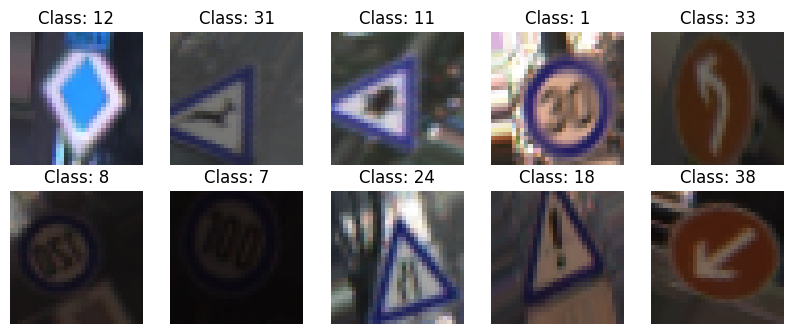

In [30]:
import matplotlib.pyplot as plt

# Visualize some augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot some examples
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f'Class: {np.argmax(augmented_labels[i])}')
    plt.axis('off')
plt.show()

In [17]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32')
    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

# Normalize pixel values (same as training data)
X_test = X_test.astype('float32') / 255.0

Skipping non-image file: GT-final_test.test.csv


##Load vgg16

In [51]:
# Here is where you can import a pre-trained model, for this case we can use VGG16, but try others!
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model.layers[:11]:  # Freeze only the first few layers
    layer.trainable = False

# Here we can add our base model to our own.
model = models.Sequential()

# Add the pre-trained base model
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('block5_pool').output
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
out = layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
model = models.Model(inputs = base_model.input, outputs = out, name='model')

In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

#from tensorflow.keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=5, steps_per_epoch=len(X_train) // 32, callbacks=[lr_scheduler])

Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.1427 - loss: 3.1471 - val_accuracy: 0.4046 - val_loss: 1.7868 - learning_rate: 0.0010
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5000 - loss: 1.7502 - val_accuracy: 0.4033 - val_loss: 1.8037 - learning_rate: 0.0010
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.3995 - loss: 1.8885 - val_accuracy: 0.5150 - val_loss: 1.4001 - learning_rate: 0.0010
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3438 - loss: 1.7650 - val_accuracy: 0.5180 - val_loss: 1.3930 - learning_rate: 0.0010
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.4645 - loss: 1.6472 - val_accuracy: 0.5408 - val_loss: 1.3111 - learning_rate: 0.0010


## Evaluate on Validation data

In [43]:
# Evaluate on Validation data
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')

# Get model predictions
y_pred = model.predict(X_val)  #predictions
y_pred_classes = np.argmax(y_pred, axis=1) #predicted_classes
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6305 - loss: 1.0715
Test accuracy: 0.6293037533760071
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.48      0.96      0.64       496
           2       0.25      0.26      0.25       450
           3       0.24      0.05      0.08       280
           4       0.56      0.29      0.38       418
           5       0.28      0.61      0.38       364
           6       0.70      0.78      0.74        59
           7       0.84      0.41      0.55       278
           8       0.00      0.00      0.00       301
           9       0.85      0.90      0.88       268
          10       0.89      0.84      0.86       370
          11       0.77      0.91      0.83       236
          12       0.97      1.00      0.98       450
          13       1.00      1.00      1.00       452
          14   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


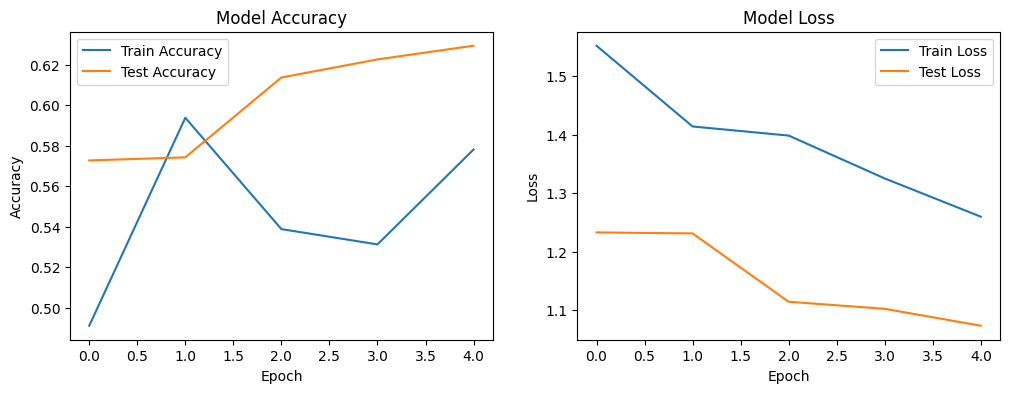

In [44]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()

##Evaluate on test data

In [45]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Predictions saved to 'gtsrb_test_predictions.csv'
Test Accuracy: 58.56%
